# EUROSAT PREPROCESSING

In [2]:
# Install libraries if collab resets
!pip install rasterio scikit-image scikit-learn tqdm torch torchvision kagglehub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [3]:
# Packages
import numpy as np
import pandas as pd
import os
import rasterio
import shutil
import torch

from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import color
from sklearn import metrics, preprocessing
from torch import nn, optim, utils
from tqdm import tqdm
from urllib import request

from PIL import Image
from torchvision import transforms

from urllib import request
import os
import shutil

from google.colab import drive
import kagglehub



Mounted at /content/drive


In [6]:
print(os.getcwd())
drive.mount('/content/drive')


/content


In [16]:
def download_data():
    target_path = '/content/drive/MyDrive/Thesis_Data/data/eurosat-dataset'
    if os.path.exists(target_path):
        print("Dataset already exists at:", target_path)
        return target_path
    path = kagglehub.dataset_download("apollo2506/eurosat-dataset")
    print("Download Temporary Path:", path)
    os.makedirs(target_path, exist_ok=True)
    shutil.move(path, target_path)
    print("Moved dataset to:", os.path.join(target_path, os.path.basename(path)))

download_data()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset already exists at: /content/drive/MyDrive/Thesis_Data/data/eurosat-dataset


'/content/drive/MyDrive/Thesis_Data/data/eurosat-dataset'

In [ ]:
# Display one image
def display_image(image: torch.Tensor, title: str = '', cmap: str = 'gray', figsize=(3, 3)) -> None:
    image = torch.einsum('dhw -> hwd', image)
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image, cmap=cmap)
    ax.set_title(title, fontsize=12)
    ax.set_axis_off()
    print(image.shape)
    plt.tight_layout()
    plt.show()
    plt.close()

#Display multiple in 2 rows

def display_images(images: list, titles: list = ['Image']) -> None:
    nimage = len(images)
    if len(titles) == 1: titles = titles * nimage

    ncols = (nimage + 1) // 2
    fig, axs = plt.subplots(nrows=2, ncols=ncols, figsize=(4 * ncols, 8))
    axs = axs.ravel()

    for i, (image, title) in enumerate(zip(images, titles)):
        image = torch.einsum('dhw -> hwd', image)
        axs[i].imshow(image)  # no cmap
        axs[i].set_title(title, fontsize=12)
        axs[i].set_axis_off()

    for j in range(i + 1, len(axs)):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()
    plt.close()

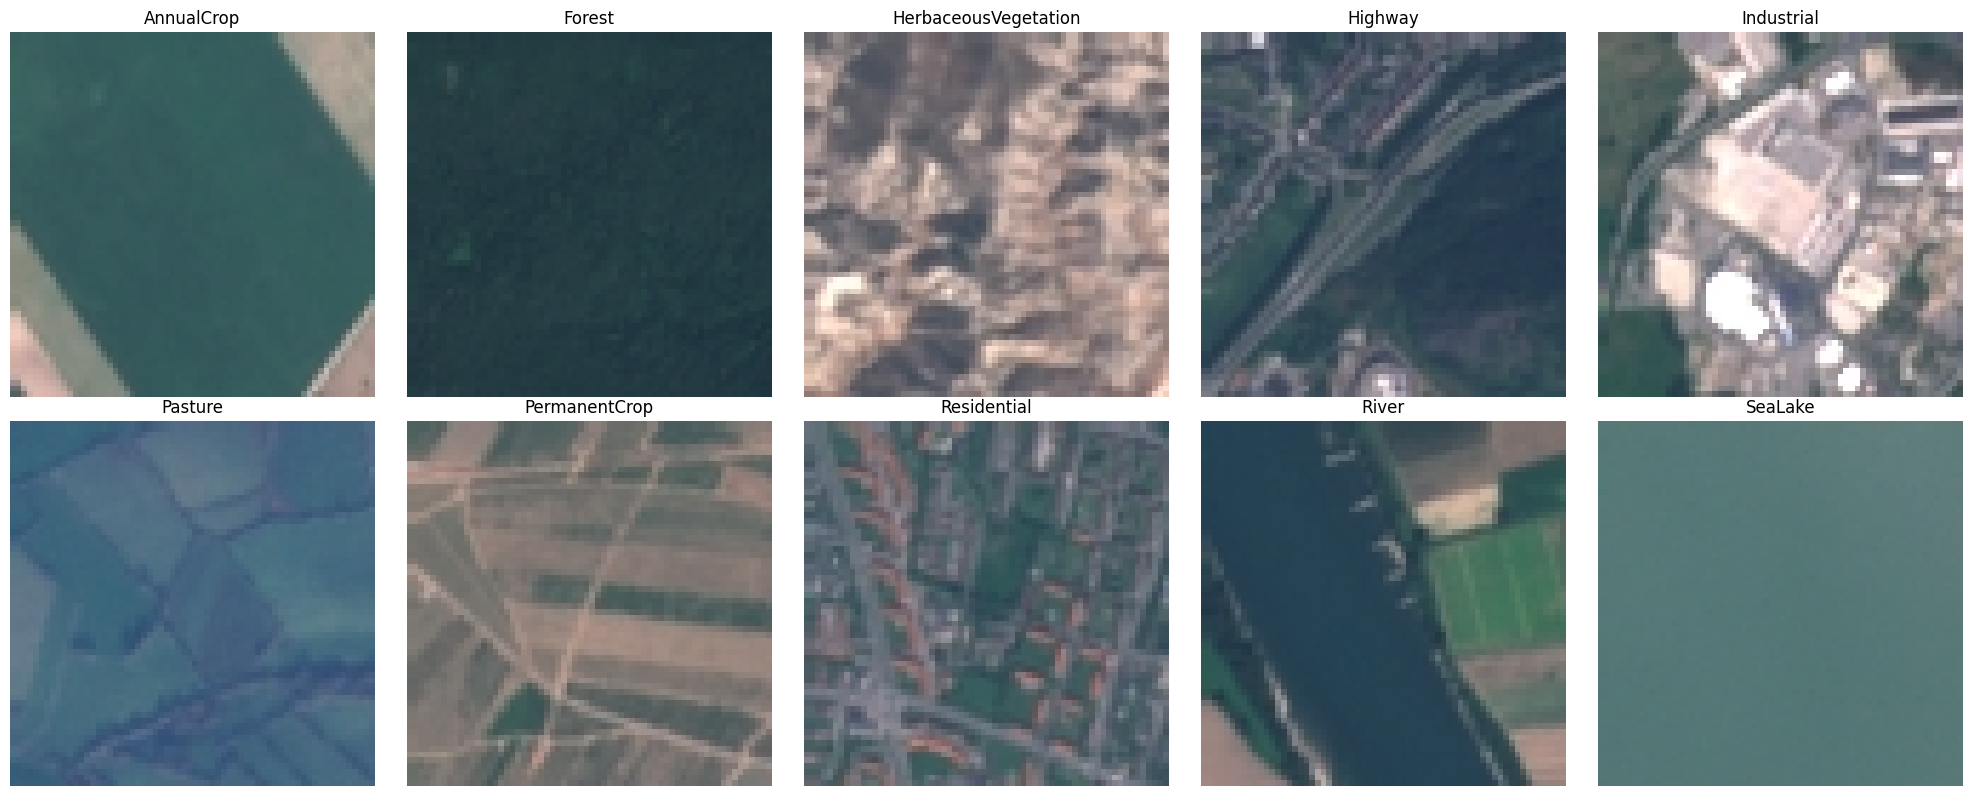

In [ ]:

# Convert to tensor (used for diffusion and classification)
transform = transforms.ToTensor()

# Base path to JPEG images
base_dir = '/content/drive/MyDrive/Thesis_Data/data/eurosat-dataset/6/EuroSAT'

# Collect one image per class folder
images = []
titles = []

for label_name in sorted(os.listdir(base_dir)):
    class_path = os.path.join(base_dir, label_name)
    if not os.path.isdir(class_path):
        continue

    for file in os.listdir(class_path):
        if file.lower().endswith(".jpg"):
            file_path = os.path.join(class_path, file)
            image = Image.open(file_path).convert("RGB")
            image_tensor = transform(image)
            images.append(image_tensor)
            titles.append(label_name)
            break  # Only one image per class

# Display all collected images in 2 rows
display_images(images=images, titles=titles)


test